In [1]:
INSTANCE_ID = "b1062c36-3d9a-4df5-ad3d-ab0d40ae3ca0"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam
from sentinelhub.common import BBox, CRS # Different than in examples
from sentinelhub import CustomUrlParam

ModuleNotFoundError: No module named 'sentinelhub'

In [5]:
import datetime
end_time = datetime.datetime.now().strftime('%Y-%m-%d')
start_time = '2017-12-01'

In [6]:
def plot_image(data, factor=1./255):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting 
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    rgb = data.astype(np.float32)
    if len(rgb.shape) == 3 and rgb.shape[2] == 3:
        rgb = rgb[..., [2, 1, 0]]
    plt.imshow(rgb * factor)

In [7]:
fmf_box = [46.042,14.487, 46.043,14.488]
fmf_box = BBox(bbox=fmf_box, crs=CRS.WGS84)

In [15]:
cloud_detect_url = 'https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/cby_cloud_detection/script.js'
trim_cloud_detect_url = 'https://raw.githubusercontent.com/jO-Osko/cloudDetector/master/cd.js'
                
data_request_orig = WmsRequest(layer='AGRICULTURE', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          custom_url_params={CustomUrlParam.SHOWLOGO: False}
                              )
    
data_request_cloud = WmsRequest(layer='AGRICULTURE', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          custom_url_params={CustomUrlParam.SHOWLOGO: False, 
                                             CustomUrlParam.EVALSCRIPTURL: cloud_detect_url}
                              )

data_request_trim = WmsRequest(layer='AGRICULTURE', data_folder='data/',
                          bbox=fmf_box,
                          time=(start_time, end_time),
                          width=10, instance_id=INSTANCE_ID, 
                          custom_url_params={CustomUrlParam.SHOWLOGO: False, 
                                             CustomUrlParam.EVALSCRIPTURL: trim_cloud_detect_url}
                             )

data_imgs_orig = data_request_orig.save_data()
data_imgs_cloud = data_request_cloud.save_data()
data_imgs_trim = data_request_trim.save_data()

In [16]:
data_imgs_orig = data_request_orig.get_data()
data_imgs_cloud = data_request_cloud.get_data()
data_imgs_trim = data_request_trim.get_data()

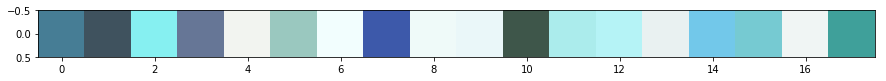

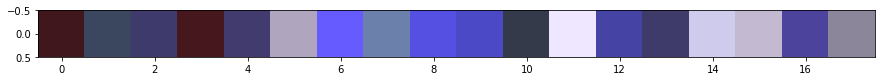

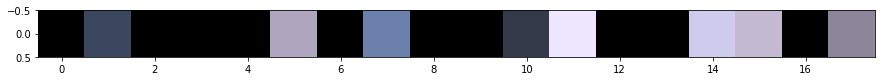

In [14]:
y_ind, x_ind = 0,6 # Pick indices
band = 3 # Pick band
arr_orig = np.array([[img[x_ind][y_ind] for img in data_imgs_orig]])
plot_image(arr_orig)

arr_cloud = np.array([[img[x_ind][y_ind] for img in data_imgs_cloud]])
plot_image(arr_cloud)

# Black ones are classified as clouds (in any way)
arr_trim = np.array([[img[x_ind][y_ind] for img in data_imgs_trim]])
plot_image(arr_trim)

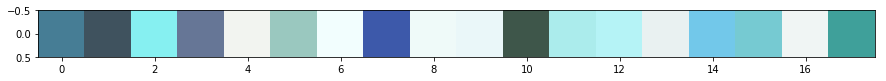

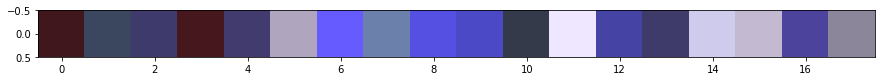

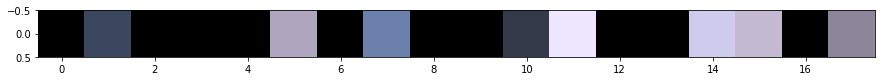

In [17]:
y_ind, x_ind = 0,6 # Pick indices
band = 3 # Pick band
arr_orig = np.array([[img[x_ind][y_ind] for img in data_imgs_orig]])
plot_image(arr_orig)

arr_cloud = np.array([[img[x_ind][y_ind] for img in data_imgs_cloud]])
plot_image(arr_cloud)

# Black ones are classified as clouds (in any way)
arr_trim = np.array([[img[x_ind][y_ind] for img in data_imgs_trim]])
plot_image(arr_trim)